# Class DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [7]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic")

c_gene = gene[mask]
c_isoform = isoform[mask]

In [8]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
gene_features = c_gene.var.gene_name.values
assignments   = c_gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw, corr_method)
s_gene = stat

22-Oct-20 17:09:10 - 1 of 2 assignments: GABAergic
22-Oct-20 17:09:11 - 2 of 2 assignments: Glutamatergic


CPU times: user 1.56 s, sys: 1.58 s, total: 3.15 s
Wall time: 3.15 s


In [9]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_isoform_raw, stat = dexpress(mat, components, features, assignments, 
                      nan_cutoff=nan_cutoff)

p_isoform = correct_pval(p_isoform_raw/2, corr_method)
s_isoform = stat

22-Oct-20 17:09:16 - 1 of 2 assignments: GABAergic
22-Oct-20 17:09:18 - 2 of 2 assignments: Glutamatergic


CPU times: user 3.72 s, sys: 4.35 s, total: 8.06 s
Wall time: 8.06 s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [10]:
repeat_col = c_gene.var["num_isoforms"]

p1 = p_isoform
p2 = np.repeat(p_gene, repeat_col, axis=1)

s1 = s_isoform
s2 = np.repeat(s_gene, repeat_col, axis=1)

In [11]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

p2_mask = np.logical_or(np.logical_and(p2>alpha, s2>tcrit), np.logical_and(p2<alpha, s2<tcrit))

mask = np.logical_and(p1_mask, p2_mask)
bool_mask = mask

In [12]:
bool_mask.sum()

312

In [13]:
assignments = c_gene.obs.class_label.values
unique = np.unique(assignments)

In [14]:
unique

array(['GABAergic', 'Glutamatergic'], dtype=object)

In [15]:
markers_isoform = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])

In [16]:
isoform_features = isoform.var.transcript_name.values

for uidx, u in enumerate(unique):
    mask = np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_isoform[uidx][mask]
    p_raw = p_isoform_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = isoform_features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_isoform.loc[u]["transcript_name"] = fsorted
    markers_isoform.loc[u]["p_raw"] = p_raw_sorted
    markers_isoform.loc[u]["p_bonferroni"] = psorted

In [17]:
markers_isoform

,transcript_name,p_raw,p_bonferroni
GABAergic,"[Myl6-206_ENSMUST00000218127, Rsrp1-201_ENSMUS...","[0.0, 2.181836645228789e-48, 1.532498096679399...","[0.0, 7.546100221188289e-44, 5.300297917175372..."
Glutamatergic,"[Caly-203_ENSMUST00000211044, Caly-202_ENSMUST...","[0.0, 0.0, 0.0, 8.811914991113803e-183, 6.6483...","[0.0, 0.0, 0.0, 3.0476889188266196e-178, 2.299..."


In [18]:
c_isoform.obs.class_label.value_counts()

Glutamatergic    4136
GABAergic        1971
Name: class_label, dtype: int64

In [19]:
[(i.split("_")[0], i.split("_")[1])  for i in markers_isoform.loc['Glutamatergic']["transcript_name"]][0:10]

[('Caly-203', 'ENSMUST00000211044'),
 ('Caly-202', 'ENSMUST00000166758'),
 ('H3f3b-204', 'ENSMUST00000139623'),
 ('Meg3-203', 'ENSMUST00000128178'),
 ('Caly-205', 'ENSMUST00000211681'),
 ('Srsf11-208', 'ENSMUST00000133090'),
 ('Oxr1-204', 'ENSMUST00000110297'),
 ('Meg3-202', 'ENSMUST00000126289'),
 ('Hsp90aa1-201', 'ENSMUST00000021698'),
 ('Cops9-204', 'ENSMUST00000148508')]

In [20]:
specific_cluster = "Glutamatergic"
specific_isoform = "H3f3b-204_ENSMUST00000139623"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [21]:
specific_gene

'H3f3b'

In [22]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['H3f3b_ENSMUSG00000016559'], dtype=object)

In [23]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [24]:
logger.setLevel(logging.ERROR)

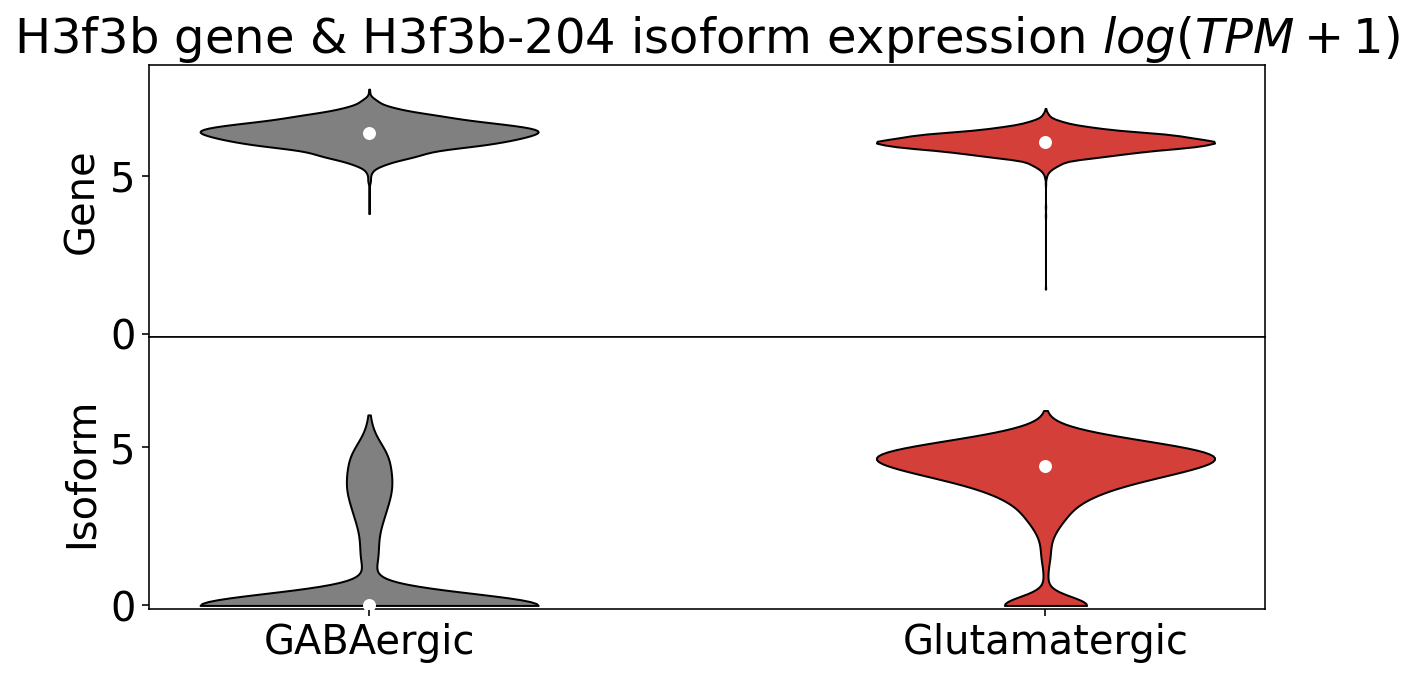

In [26]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[0].set_ylabel("Gene")

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

ax[0].set_ylim((-0.1, 8.5))
medians = [np.median(i) for i in x]
#ax[1].axhline(y=medians[midx], color="k", linestyle="--")

ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=0, ha="center")
ax[1].set_ylabel("Isoform")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} isoform expression $log(TPM + 1)$".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]))
plt.savefig("../../figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

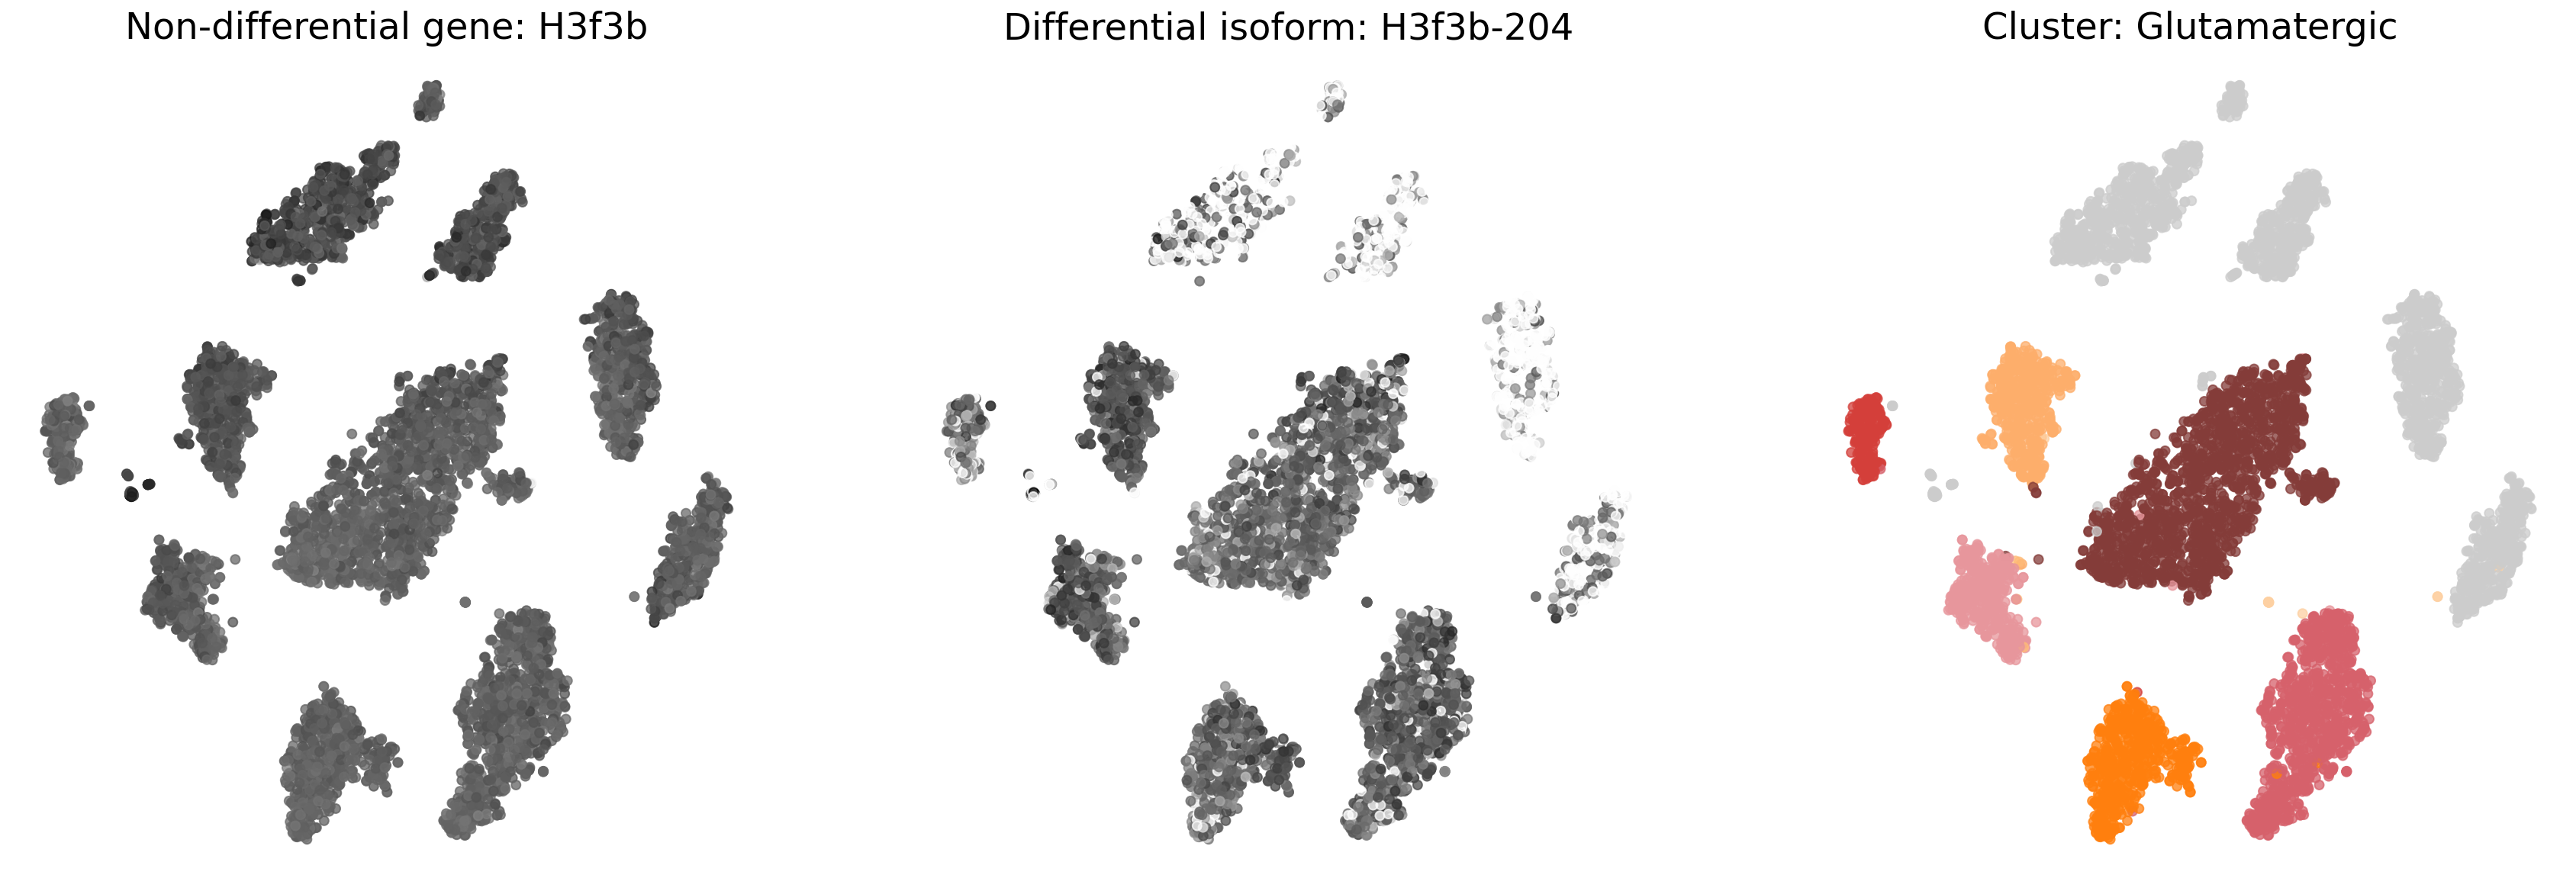

In [27]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["class_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("../../figures/class_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [28]:
identified_isoforms = markers_isoform["transcript_name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [29]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [30]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

312 isoforms from 260 genes identified.


In [31]:
markers_isoform["transcript_name"].explode()

GABAergic           Myl6-206_ENSMUST00000218127
GABAergic          Rsrp1-201_ENSMUST00000078084
GABAergic          Gapdh-203_ENSMUST00000118875
GABAergic          Rplp2-201_ENSMUST00000084434
GABAergic           Rtn1-203_ENSMUST00000137990
                              ...              
Glutamatergic    Selenok-203_ENSMUST00000223998
Glutamatergic    Sparcl1-201_ENSMUST00000031249
Glutamatergic       Glrx-201_ENSMUST00000022082
Glutamatergic      Rbbp4-201_ENSMUST00000102598
Glutamatergic      Ap4s1-201_ENSMUST00000021338
Name: transcript_name, Length: 312, dtype: object

In [32]:
markers_isoform["p_raw"].explode()

GABAergic                  0
GABAergic        2.18184e-48
GABAergic         1.5325e-42
GABAergic        1.93259e-34
GABAergic        2.71708e-32
                    ...     
Glutamatergic    1.50656e-07
Glutamatergic    1.50828e-07
Glutamatergic    1.65427e-07
Glutamatergic    1.87901e-07
Glutamatergic    2.71323e-07
Name: p_raw, Length: 312, dtype: object

In [33]:
markers_isoform = markers_isoform.apply(pd.Series.explode).reset_index()

In [34]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni
0,GABAergic,Myl6-206_ENSMUST00000218127,0,0
1,GABAergic,Rsrp1-201_ENSMUST00000078084,2.18184e-48,7.5461e-44
2,GABAergic,Gapdh-203_ENSMUST00000118875,1.5325e-42,5.3003e-38
3,GABAergic,Rplp2-201_ENSMUST00000084434,1.93259e-34,6.68406e-30
4,GABAergic,Rtn1-203_ENSMUST00000137990,2.71708e-32,9.39728e-28
...,...,...,...,...
307,Glutamatergic,Selenok-203_ENSMUST00000223998,1.50656e-07,0.0052106
308,Glutamatergic,Sparcl1-201_ENSMUST00000031249,1.50828e-07,0.00521655
309,Glutamatergic,Glrx-201_ENSMUST00000022082,1.65427e-07,0.00572146
310,Glutamatergic,Rbbp4-201_ENSMUST00000102598,1.87901e-07,0.00649874


In [35]:
markers_isoform.to_csv("../../tables/unordered/class_DE.csv")